# Overview

We will:

1. Estimate a production function using neural network 
2. Solve a optimization problem using the estimated function

In [228]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Single input power production

We will generate *i.i.d* samples of $(x_i, y_i)$ by the following procedure:

1. $\log(x_i) \sim \mathrm{Normal}(0, 1)$, $\log(\epsilon_i) \sim \mathrm{Normal}(0, 0.1)$
2. $y_i = \epsilon x_{i}^{\alpha}$, where $\alpha \in (0, 1)$ is predetermined.

Using the data $\{(x_i, y_i)\}_{i=1}^{n}$, we will estimate the production function $f(x)$ that predicts $y$ by the neural network. 

Then, we will solve the following (unconstrained) maximization problem:

$$
\mathrm{max}_{x}\;\; f(x) - p x
$$
where $p > 0$ is a known parameter that represents the input price. 


The solution with the true function with $\epsilon=1$ is $x^* = \left(\frac{p}{\alpha}\right)^{\frac{1}{\alpha-1}}$.
We expect that the optimization problem obtains a closer value to this.

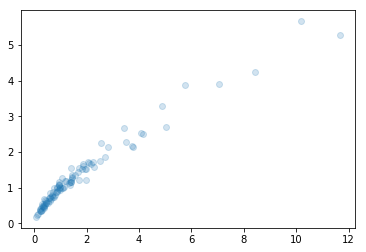

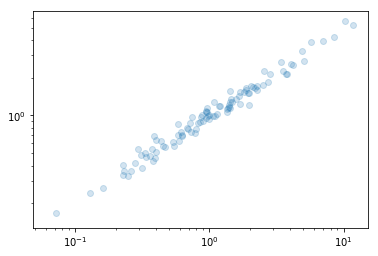

In [229]:
# define data generating functions
def power_product_func(x, epsilon, alpha):
    y = epsilon * np.power(x, alpha)
    return y

def generate_power_data(n, alpha):
    x = np.random.lognormal(0, 1, n)
    eps = np.random.lognormal(0, 0.1, n)
    y = power_product_func(x, eps, alpha)
    return x, y

# test
np.random.seed(87)
x, y = generate_power_data(100, 0.7)
plt.scatter(x, y, alpha=0.2)
plt.show()

plt.scatter(x, y, alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.show()


We will estimate the production function by log-log model, *i.e.,* estimating the mapping from $\log(x)$ to $\log(y)$.
We will fit the data to a neural network model.
Note that for current setting linear regression model would suffice since the data-generating model can be written as $\log(y_i) = \alpha \log(x_i) + \log(\epsilon).$
Nonetheless we use neural network pretending that we do not know the underlining model.

In [230]:
# define estimating architecture
tf.reset_default_graph()
n_hidden = 32

x_in = tf.placeholder(tf.float32, shape=[None, 1], name="x_in")
y_in = tf.placeholder(tf.float32, shape=[None, 1], name="y_in")

keep_prob = tf.placeholder_with_default(1.0, shape=(), name="keep_prob")
train_rate = tf.placeholder_with_default(0.2, shape=(), name="train_rate")


## convert to log scale
log_x = tf.log(x_in)
log_y = tf.log(y_in)


## first hidden layer
w1 = tf.get_variable("w1", [1, n_hidden], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable("b1", [n_hidden]   , initializer=tf.contrib.layers.xavier_initializer())
a1 = tf.nn.tanh(tf.matmul(log_x, w1) + b1)
a1_drop = tf.nn.dropout(a1, keep_prob=keep_prob)

## second hidden layer
w2 = tf.get_variable("w2", [n_hidden, n_hidden], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable("b2", [n_hidden]          , initializer=tf.contrib.layers.xavier_initializer())
a2 = tf.nn.tanh(tf.matmul(a1_drop, w2) + b2)
a2_drop = tf.nn.dropout(a2, keep_prob=keep_prob)

## output layer
w3 = tf.get_variable("w3", [n_hidden, 1], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.get_variable("b3", [1]    , initializer=tf.contrib.layers.xavier_initializer())
log_yhat = tf.matmul(a2_drop, w3) + b3

## training
loss  = tf.reduce_mean(tf.square(log_yhat - log_y))
train = tf.train.GradientDescentOptimizer(train_rate).minimize(loss)

## prediction in the original scale
yhat = tf.exp(log_yhat)

In [231]:
# data prep
np.random.seed(87)

alpha = 0.5
n_tr = 1000
# training data
x_tr, y_tr = generate_power_data(n_tr, alpha)
# test data
n_te = 250
x_te, y_te = generate_power_data(n_te, alpha)


data = {x_in: x_tr.reshape((-1, 1)), y_in: y_tr.reshape((-1, 1)), 
        keep_prob: 0.5, train_rate: 0.1}
data_te = {x_in: x_te.reshape((-1, 1))}

In [232]:
tf.set_random_seed(875)
nepoch = 5000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(nepoch):
        sess.run(train, data)
        if i % (nepoch/10) == 0:
            print(i, ") loss:", sess.run(loss, data))
            
    print(sess.run(loss, data))

    # generate test data and predictioni
    yhat_te = sess.run(yhat, data_te)
    parameters = {'w1': w1.eval(), 'b1': b1.eval(), 
                  'w2': w2.eval(), 'b2': b2.eval(),
                  'w3': w3.eval(), 'b3': b3.eval()}

(0, ') loss:', 0.80030066)
(500, ') loss:', 0.03370437)
(1000, ') loss:', 0.029933266)
(1500, ') loss:', 0.02864904)
(2000, ') loss:', 0.027153963)
(2500, ') loss:', 0.029127713)
(3000, ') loss:', 0.026272753)
(3500, ') loss:', 0.026057623)
(4000, ') loss:', 0.024968723)
(4500, ') loss:', 0.026468262)
0.0240339


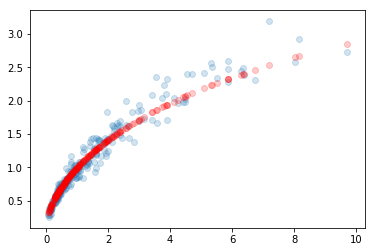

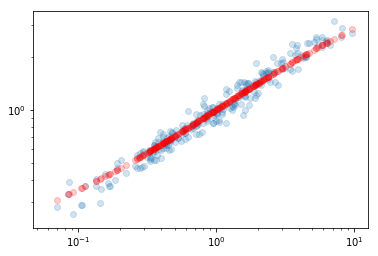

In [233]:
plt.scatter(x_te, y_te, alpha=0.2)
plt.scatter(x_te, yhat_te, c='r', alpha=0.2)
plt.show()

plt.scatter(x_te, y_te, alpha=0.2)
plt.scatter(x_te, yhat_te, c='r', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [234]:
# define optimization architecture
tf.reset_default_graph()

## x is now a trainable variable
log_x = tf.get_variable('log_x', shape=[1,1], dtype=tf.float32, 
                        initializer=tf.contrib.layers.xavier_initializer())

## first hidden layer
## note that parameters are now constant
w1 = tf.constant(parameters['w1'], dtype=tf.float32, name="w1")
b1 = tf.constant(parameters['b1'], dtype=tf.float32, name="b1")
a1 = tf.nn.relu(tf.matmul(log_x, w1) + b1)
#a1_drop = tf.nn.dropout(a1, keep_prob=keep_prob)  # no need anymore!

## second hidden layer
w2 = tf.constant(parameters['w2'], dtype=tf.float32, name="w2")
b2 = tf.constant(parameters['b2'], dtype=tf.float32, name="b2")
a2 = tf.nn.relu(tf.matmul(a1, w2) + b2)
# a2_drop = tf.nn.dropout(a2, keep_prob=keep_prob)

## output layer
w3 = tf.constant(parameters['w3'], dtype=tf.float32, name="w3")
b3 = tf.constant(parameters['b3'], dtype=tf.float32, name="b3")
log_yhat = tf.matmul(a2, w3) + b3

yhat = tf.exp(log_yhat)
x = tf.exp(log_x)


## optimizer
train_rate = tf.placeholder_with_default(0.2, shape=(), name="train_rate")
price= tf.placeholder(tf.float32, shape=(), name="price")
objective = tf.squeeze(price * x - yhat)
train = tf.train.GradientDescentOptimizer(train_rate).minimize(objective)

In [236]:
tf.set_random_seed(875)
p = 3.3
data = {price: p, train_rate: 0.1}

nepoch = 3000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(nepoch):
        sess.run(train, data)
    x_star = x.eval(data)[0][0]
print("x star (log)) = %f (%f)" % (x_star, np.log(x_star)))
expected = (p/alpha)**(1/(alpha-1))
print("expected (log) = %f (%f)" % (expected, np.log(expected)))

x star (log)) = 0.024342 (-3.715549)
expected (log) = 0.022957 (-3.774139)


### Two-input Cobb-Douglas Production

We will generate a dummy data of $(K, L, Y)$ from $Y = K^\alpha L^{1-\alpha}$ and estimate $Y = f(K, L)$ by neural net. Then, we will maximize: $f(K, L)$ subject to $r K + w L = M$.

This optimization problem has an analytic solution:

$K^* = \frac{\alpha M}{r}, L^* = \frac{(1-\alpha)M}{w}$

In [249]:
def cobb_douglas(K, L, alpha):
    Y = np.power(K, alpha) * np.power(L, 1-alpha)
    return Y

def generate_cobb_douglas(N, alpha):
    """
    Generate (K, L, Y) such that Y = K^alpha L^(1-alpha) 
    
    K and L are generated from independent exponential distribution with mean 1
    
    N       : number of observation
    alpha   : power to K
    sigma   : standard deviation of epsilon 
    """
    K = np.random.exponential(1, (N,))
    L = np.random.exponential(1, (N,))
    Y = cobb_douglas(K, L, alpha)
    
    return K, L, Y

Ks, Ls, Ys = generate_cobb_douglas(100, 0.3)

# this should be very close to zero
np.max(np.abs(np.log(Ys) - 0.3 * np.log(Ks) - 0.7 * np.log(Ls)))

4.4408920985006262e-16

In [264]:
tf.reset_default_graph()

# 4 layer full-connected neural net
X  = tf.placeholder(tf.float32, shape=[None, 2])

W1 = tf.get_variable("W1", shape=[2, 20], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable("b1", shape=[20], initializer=tf.contrib.layers.xavier_initializer())
A1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.get_variable("W2", shape=[20, 20], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable("b2", shape=[20], initializer=tf.contrib.layers.xavier_initializer())
A2 = tf.nn.relu(tf.matmul(A1, W2) + b2)

W3 = tf.get_variable("W3", shape=[20, 20], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.get_variable("b3", shape=[20], initializer=tf.contrib.layers.xavier_initializer())
A3 = tf.nn.relu(tf.matmul(A2, W3) + b3)

W4 = tf.get_variable("W4", shape=[20, 1], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.get_variable("b4", shape=[1], initializer=tf.contrib.layers.xavier_initializer())
O  = tf.matmul(A3, W4) + b4

# squared error 
Y = tf.placeholder(tf.float32)    
loss = tf.reduce_mean(tf.square(O - Y))

# optimizer
train = tf.train.GradientDescentOptimizer(0.2).minimize(loss)

In [267]:
alpha = 0.4
Ks, Ls, Ys = generate_cobb_douglas(1000, alpha)
in_x = np.vstack((Ks, Ls)).transpose()
in_y = Ys.reshape(1000, 1)

data = {X: in_x, Y: in_y}

nepoch = 5000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(nepoch):
        sess.run(train, feed_dict=data)
        if i % (nepoch/10) == 0:
            print(i, sess.run(loss, data))
    print(sess.run(loss, data))
    
    # generate (K, L, Y) from the model
    Ks, Ls, Ys = generate_cobb_douglas(1000, 0.3)
    Yhat = sess.run(O, {X: np.vstack((Ks, Ls)).transpose()})
    
    # keep the trained weights and biases
    parameters = {
        "W1": W1.eval(), "b1": b1.eval(),
        "W2": W2.eval(), "b2": b2.eval(),
        "W3": W3.eval(), "b3": b3.eval(),
        "W4": W4.eval(), "b4": b4.eval(),
    }

(0, 7.8628983)
(500, 0.018959712)
(1000, 0.010113688)
(1500, 0.0058739148)
(2000, 0.0039038197)
(2500, 0.0029621432)
(3000, 0.0022913213)
(3500, 0.0018316223)
(4000, 0.0016447332)
(4500, 0.0014418914)
0.00183843


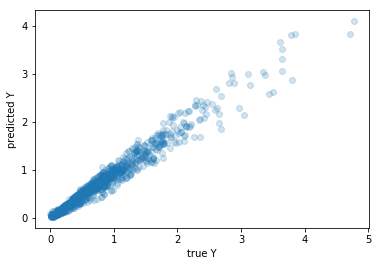

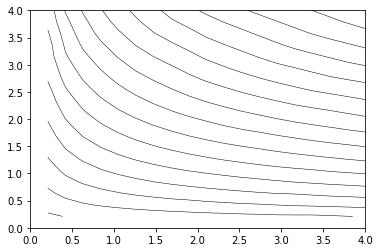

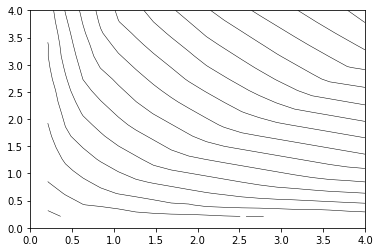

In [268]:
# plot the result
plt.scatter(Ys, Yhat, alpha=0.2)
plt.xlabel("true Y")
plt.ylabel("predicted Y")
plt.show()

# contour plot
def my_contour(x, y, z, xmin=0, xmax=4, nx=20, ymin=0, ymax=4, ny=20):
    xi = np.linspace(xmin, xmax, nx)
    yi = np.linspace(ymin, ymax, ny)
    zi = ml.griddata(x, y, z, xi, yi, interp='linear')
    
    plt.contour(xi, yi, zi, 15, linewidths = 0.5, colors = 'k')
    plt.show()
my_contour(Ks, Ls, Ys)

my_contour(Ks, Ls, Yhat.squeeze())

In [269]:
tf.reset_default_graph()

# create network for optimization

# setting parameters 
M = tf.placeholder(tf.float32, shape=[1])
r = tf.placeholder(tf.float32, shape=[1])
w = tf.placeholder(tf.float32, shape=[1])

# model weights, these are fixed in this exercise
W1 = tf.constant(parameters["W1"], dtype=tf.float32)
b1 = tf.constant(parameters["b1"], dtype=tf.float32)
W2 = tf.constant(parameters["W2"], dtype=tf.float32)
b2 = tf.constant(parameters["b2"], dtype=tf.float32)
W3 = tf.constant(parameters["W3"], dtype=tf.float32)
b3 = tf.constant(parameters["b3"], dtype=tf.float32)
W4 = tf.constant(parameters["W4"], dtype=tf.float32)
b4 = tf.constant(parameters["b4"], dtype=tf.float32)


K = tf.Variable([0.5], dtype=tf.float32, name="K")
L = (M - r*K) / w

X = tf.stack([K, L], axis=1)

A1 = tf.nn.relu(tf.matmul(X, W1) + b1)
A2 = tf.nn.relu(tf.matmul(A1, W2) + b2)
A3 = tf.nn.relu(tf.matmul(A2, W3) + b3)
O  = tf.squeeze(tf.matmul(A3, W4) + b4)

optimizer = tf.train.GradientDescentOptimizer(0.1)
train = optimizer.minimize(-1*O)

In [270]:
data = {M:[2.5], r :[0.6], w:[0.2]}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        sess.run(train, data)
    
    res = sess.run([K, L, O], data)
    print('estimated (K, L, Y) = (%f, %f, %f)' % (res[0], res[1], res[2]))

# Expected answer:
#   K = alpha*M/r
#   L = (1-alpha)*M/w
M_ = data[M][0]
r_ = data[r][0]
w_ = data[w][0]
K_star = alpha * M_ / r_
L_star = (1-alpha) * M_ / w_
Y_star = cobb_douglas(K_star, L_star, alpha)
print("expected  (K, L, Y) = (%f, %f, %f)" % (K_star, L_star, Y_star))

estimated (K, L, Y) = (1.778584, 7.164247, 4.066023)
expected  (K, L, Y) = (1.666667, 7.500000, 4.109380)
